# 4.6: 生成式张量网络与量子采样

核心任务：利用GMPS（$|\varphi\rangle$）与量子采样，实现样本生成（generation）

1. 对于第m个特征的生成，需依据量子力学原理（参考2.6节）计算边缘概率
   $p(x_m) = \langle\phi_m|\hat{\rho}^{(m)}|\phi_m\rangle$

   其中$\hat{\rho}^{(m)} = \text{Tr}_{/m}|\varphi\rangle\langle\varphi|$，$|\phi_m\rangle$为特征$x_m$进行量子特征映射后得到的量子态。
2. 得到概率分布$p(x_m)$后，特征$x_m$取值的生成方式有多种，例如可直接根据概率分布进行采样，或计算最概然的取值$\text{argmax}_{x_m}[p(x_m)]$，或计算$x_m$的概率期望值$\langle x_m\rangle_{p(x_m)} = \int p(x_m)x_m dx_m$等

## 投影测量

对于已知或已生成的特征，我们对GMPS进行投影测量：

$|\varphi'\rangle = \frac{1}{Z}\langle\Phi_m|\varphi\rangle$

张量网络图如下
![mps_projection](./images/mps_projection.png)

测量后的量子态仍满足玻恩概率诠释，描述其余位置量子态的概率分布

### GMPS 生成

已知部分特征取值（记其位置的集合为$\mathcal{A}$）的情况下，利用GMPS对另一部分特征（记其位置的集合为$\mathcal{B}$）进行生成。我们将除$\mathcal{A}$与$\mathcal{B}$外的其余特征位置构成的集合记为$\mathcal{C}$，即$\mathcal{A} \cup \mathcal{B} \cup \mathcal{C}$构成样本全部特征的位置集合

测量后量子态的边缘概率为测量前量子态的条件概率：

$$p(\{x_m\}(m \in \mathcal{B})|\{x_{m'}\}(m' \in \mathcal{A})) = \left(\prod_{m\in\mathcal{B}}|\phi_m|\right)\hat{\rho}^{(\mathcal{B})}\left(\prod_{m\in\mathcal{B}}|\phi_m|\right)$$

约化密度矩阵$\hat{\rho}^{(B)}$由测量后量子态所得，如下图
![mps_reduced_density_matrix](./images/mps_reduced_density_matrix_calculation.png)

### Code

In [1]:
from tensor_network.mps.modules import MPS
import torch
from typing import List, Self

In [2]:
# |export mps.functional
from copy import deepcopy
from einops import einsum


def project_multi_qubits(
    mps_local_tensors: List[torch.Tensor],
    qubit_indices: List[int],
    project_to_states: torch.Tensor | List[int],
) -> List[torch.Tensor]:
    """
    Do projection of multiple qubits of MPS, giving new local tensors of a new MPS.

    Args:
        mps_local_tensors: List of local tensors of the MPS.
        qubit_indices: List of indices of the qubits to project.
        project_to_states: List of states to project to.

    Returns:
        List of new local tensors of the MPS.
    """
    assert isinstance(project_to_states, (torch.Tensor, List)), "states must be a tensor or a list"
    qubit_indices = deepcopy(qubit_indices)
    project_qubit_num = len(qubit_indices)
    if isinstance(project_to_states, torch.Tensor):
        assert project_to_states.ndimension() == 2, (
            "states must be a 2D tensor"
        )  # (feature_num, channel)
        assert project_to_states.shape[0] == project_qubit_num, (
            "feature_num must match qubit_indices"
        )
        is_vec = True
    else:
        assert isinstance(project_to_states, List), "project_to_states must be a list"
        assert len(project_to_states) == project_qubit_num, (
            "project_to_states must match qubit_indices"
        )
        is_vec = False

    local_tensors = [i for i in mps_local_tensors]

    if project_qubit_num == 0:
        return local_tensors

    if is_vec:
        for i, qubit_idx in enumerate(qubit_indices):
            local_tensor = local_tensors[qubit_idx]
            project_to_state = project_to_states[i]
            assert local_tensor.shape[1] == project_to_state.shape[0], (
                "The feature dimension of the project_to_states must match the physical dimension of the local tensor of MPS"
            )
            local_tensors[qubit_idx] = einsum(
                local_tensor, project_to_state, "left physical right, physical -> left right"
            )
    else:
        for i, qubit_idx in enumerate(qubit_indices):
            local_tensor = local_tensors[qubit_idx]
            state_idx = project_to_states[i]
            assert 0 <= state_idx < local_tensor.shape[1], (
                f"state_idx must be in [0, {local_tensor.shape[1]}), got {state_idx}"
            )
            local_tensors[qubit_idx] = local_tensor[:, state_idx, :]

    # sort qubit_indices in descending order to safely pop tensors
    qubit_indices.sort(reverse=True)
    RIGHT_DIM = -1
    LEFT_DIM = 0
    for qubit_idx in qubit_indices[:-1]:
        assert qubit_idx > 0
        qubit_left = qubit_idx - 1
        local_tensors[qubit_left] = torch.tensordot(
            local_tensors[qubit_left], local_tensors[qubit_idx], dims=[[RIGHT_DIM], [LEFT_DIM]]
        )
        local_tensors.pop(qubit_idx)

    if len(local_tensors) > 1:
        qubit_idx = qubit_indices[-1]
        if qubit_idx == 0:
            qubit_right = 1
            local_tensors[qubit_right] = torch.tensordot(
                local_tensors[qubit_idx], local_tensors[qubit_right], dims=[[RIGHT_DIM], [LEFT_DIM]]
            )
        else:
            qubit_left = qubit_idx - 1
            local_tensors[qubit_left] = torch.tensordot(
                local_tensors[qubit_left], local_tensors[qubit_idx], dims=[[RIGHT_DIM], [LEFT_DIM]]
            )

        local_tensors.pop(qubit_idx)
    else:
        # do nothing if there is only one tensor left
        pass

    for i in range(len(local_tensors)):
        local_tensor = local_tensors[i]
        if local_tensor.ndimension() == 2:
            local_tensor = local_tensor.unsqueeze(1)  # (left, right) -> (left, 1, right)
        else:
            assert local_tensor.ndimension() == 3, "Unexpected tensor dimension: bug?"

        local_tensors[i] = local_tensor

    return local_tensors

In [3]:
# |export mps.modules
from tensor_network.mps.functional import project_multi_qubits as project_multi_qubits_func
from fastcore.basics import patch


@patch
def project_multi_qubits(
    self: MPS, qubit_indices: List[int], project_to_states: torch.Tensor | List[int]
) -> Self:
    """
    Do projection of multiple qubits of this MPS, returning a new MPS.

    Args:
        qubit_indices: List of indices of the qubits to project.
        project_to_states: List of states to project to.

    Returns:
        MPS, the new MPS after projection.
    """
    local_tensors = self._mps
    new_local_tensors = project_multi_qubits_func(local_tensors, qubit_indices, project_to_states)
    return MPS(mps_tensors=new_local_tensors)


@patch
def project_one_qubit(self: MPS, qubit_idx: int, project_to_state: torch.Tensor | int) -> Self:
    """
    Project one qubit of this MPS, returning a new MPS.

    Args:
        qubit_idx: int, the index of the qubit to project.
        project_to_state: torch.Tensor | int, the state to project to.
    """
    assert isinstance(project_to_state, (torch.Tensor, int)), (
        "project_to_state must be a tensor or an integer"
    )
    if isinstance(project_to_state, int):
        project_to_states = [project_to_state]
    else:
        assert project_to_state.ndimension() == 1, "project_to_state must be a 1D tensor"
        project_to_states = project_to_state.unsqueeze(0)

    qubit_indices = [qubit_idx]
    return self.project_multi_qubits(qubit_indices, project_to_states)

In [4]:
# |export algorithms.gmps

import numpy as np
from tensor_network.feature_mapping import cossin_feature_map
from copy import deepcopy
from typing import Literal, Dict, Any


def generate_sample_with_gmps(
    mps: MPS,
    *,
    sample: torch.Tensor | None,
    sample_num: int,
    gen_indices: List[int] | None,
    feature_mapping: Literal["cossin"],
    feature_mapping_kwargs: Dict[str, Any] = {},
    gen_order: Literal["ascending", "descending"] = "ascending",
):
    """
    Generate a sample with GMPS.

    Args:
        mps: MPS to generate sample from.
        sample: Sample to partially sample from. If None, sample and generate from all qubits.
        sample_num: Number of samples to average over.
        gen_indices: Indices of the qubits to generate.
        feature_mapping: Feature mapping to use.
        feature_mapping_kwargs: Keyword arguments for the feature mapping.
    """
    assert sample_num > 0, "sample_num must be positive"
    assert gen_order in ["ascending", "descending"], "gen_order must be 'ascending' or 'descending'"
    assert feature_mapping in ["cossin"], "feature_mapping must be 'cossin'"
    length = mps.length
    generate_all = False
    if sample is None or gen_indices is None:
        if gen_order == "ascending":
            gen_indices = list(range(length))
        else:
            gen_indices = list(range(length - 1, -1, -1))
        sample = None
        generate_all = True

    if generate_all:
        sample = torch.zeros(length, device=mps.device, dtype=mps.dtype)
    else:
        assert sample.shape in [(length,), (1, length)], (
            f"sample cannot be batched, got one with shape {sample.shape}"
        )
        sample = sample.squeeze()  # (length,)
        project_indices = list(range(length))
        for gi in gen_indices:
            project_indices.remove(gi)
        sample_for_projection = sample[project_indices]
        if feature_mapping == "cossin":
            features_for_projection = cossin_feature_map(
                sample_for_projection, **feature_mapping_kwargs
            )
        else:
            raise ValueError(f"Feature mapping {feature_mapping} not supported")
        features_for_projection = features_for_projection.squeeze(
            0
        )  # get rid of the batch dimension
        mps = mps.project_multi_qubits(project_indices, features_for_projection)

    # Remap gen_indices in case of a new mps after projection
    # the two argsorts effectively give the ranking of each in gen_indices, which is a new item in gen_indices_new
    # in the case that sample is None, gen_indices_new is the same as gen_indices
    #
    # the algorithm is the same as below:
    # ```
    # indices = np.argsort(np.argsort(gen_indices))
    # ranks = [None for _ in len(gen_indices)]
    # for i in len(gen_indices):
    #     original_index = indices[i]
    #     rank = i
    #     ranks[original_index] = rank
    # gen_indices_new = ranks
    # ```
    #
    # This remapping is needed since project_indices will be projected and removed from the new MPS
    gen_indices = np.array(gen_indices)
    gen_indices_new = np.argsort(
        np.argsort(gen_indices)
    )  # TODO: refactor the function - this line is not useful when generate_all is True

    # defensive coding
    if generate_all:
        assert np.all(gen_indices_new == gen_indices), (
            "gen_indices_new should be the same as gen_indices"
        )

    samples = []
    for _ in range(sample_num):
        sample_i = sample.clone()
        mps_i = deepcopy(mps)
        gen_indices_i = gen_indices_new.copy()
        pos = 0
        while len(gen_indices_i) > 0:
            gen_idx = gen_indices_i[0]
            mps_i.center_orthogonalization_(gen_idx, mode="qr", normalize=True)
            rdm = mps_i.one_body_reduced_density_matrix(idx=gen_idx, do_tracing=True)
            assert rdm.shape == (2, 2)
            lm = rdm.diag()
            prob_1 = lm[1]
            p1 = prob_1.cpu().item()
            assert 0.0 <= p1 <= 1.0, f"probability should be between 0 and 1, got {p1}"
            state = torch.bernoulli(prob_1).to(torch.long).cpu().item()
            gen_idx_on_sample = gen_indices[pos]
            sample_i[gen_idx_on_sample] = state
            new_mps_i = mps_i.project_one_qubit(gen_idx, state)
            # the center of mps_i is gen_idx and the qubit at gen_idx has been projected
            new_mps_i._center = max(0, mps_i.center - 1)
            mps_i = new_mps_i
            # update gen_indices_i since mps_i has been projected
            gen_indices_i[gen_indices_i > gen_idx] -= 1
            gen_indices_i = gen_indices_i[1:]
            pos += 1

        samples.append(sample_i)

    samples = torch.stack(samples)
    generated_sample = samples.mean(dim=0)
    return generated_sample

#### Generation

In [5]:
from matplotlib import pyplot as plt
from tensor_network.utils.data import load_mnist_images

In [6]:
# Hyper-parameters from 4-5.ipynb
FEATURE_MAPPING = "cossin"
FEATURE_MAPPING_KWARGS = {"theta": 0.5}
MNIST_NORMALIZATION = False

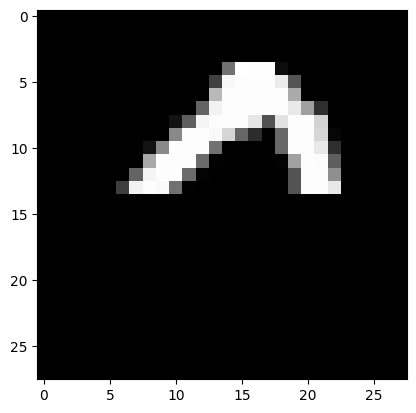

In [7]:
img_0 = load_mnist_images(
    cache_path="datasets/MNIST",
    num=1,
    from_subset="test",
    shuffle=True,
    classes=0,
    normalization=MNIST_NORMALIZATION,
)
img_0 = img_0.squeeze()
img_0[14:, :] = 0
plt.imshow(img_0, cmap="gray")
plt.show()
img_0_flatten = img_0.flatten()
gen_indices = list(range(392, 784))

In [8]:
def generate_and_plot(
    *, mps: MPS, sample: torch.Tensor | None, gen_indices: List[int] | None, sample_nums: List[int]
):
    images = []

    for sample_num in sample_nums:
        img = generate_sample_with_gmps(
            mps,
            sample=sample,
            sample_num=sample_num,
            gen_indices=gen_indices,
            feature_mapping=FEATURE_MAPPING,
            feature_mapping_kwargs=FEATURE_MAPPING_KWARGS,
        )
        img = img.reshape(28, 28)
        images.append(img)

    plt.figure(figsize=(10, 2.5))
    for i, img in enumerate(images):
        plt.subplot(1, len(sample_nums), i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Sample {sample_nums[i]}")
    plt.tight_layout()
    plt.show()

##### From Reference Weights

In [9]:
import tensor_network.setup_ref_code_import
import Library.BasicFun as bf

# Reference weight can be download from https://drive.google.com/file/d/1KJHY0_4qJOWnMldlikO1kwl04V121eqz/view?usp=sharing
# Thanks Prof.Ran!

tensors, para = bf.load(
    "datasets/mps/ref/GMPS_chi64_theta1.0_FM_cossin_digit_0",
    ["tensors", "paraMPS"],
)
for i, t in enumerate(tensors):
    tensors[i] = t.to(torch.float32)

mps_ref_weights = MPS(mps_tensors=tensors)

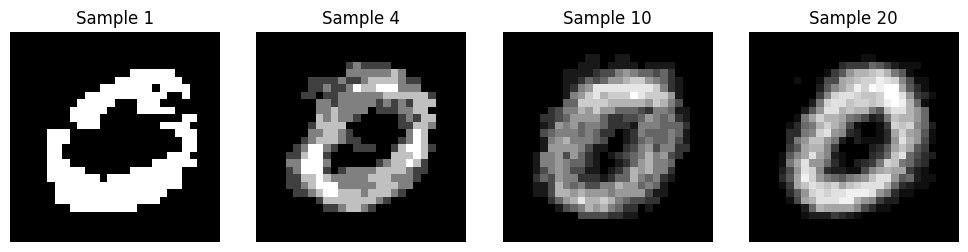

In [10]:
generate_and_plot(mps=mps_ref_weights, sample=None, gen_indices=None, sample_nums=[1, 4, 10, 20])

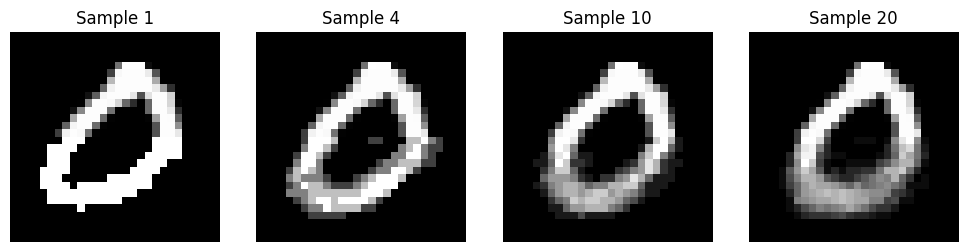

In [11]:
generate_and_plot(
    mps=mps_ref_weights, sample=img_0_flatten, gen_indices=gen_indices, sample_nums=[1, 4, 10, 20]
)

##### From Weights (Class 0) from 4-5.ipynb

In [12]:
mps_4_5 = MPS.load_from_safetensors("datasets/mps/mnist_0_mps.safetensors", requires_grad=False)

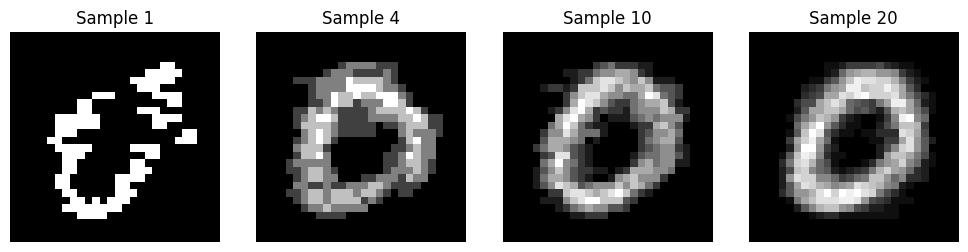

In [ ]:
generate_and_plot(mps=mps_4_5, sample=None, gen_indices=None, sample_nums=[1, 4, 10, 20])

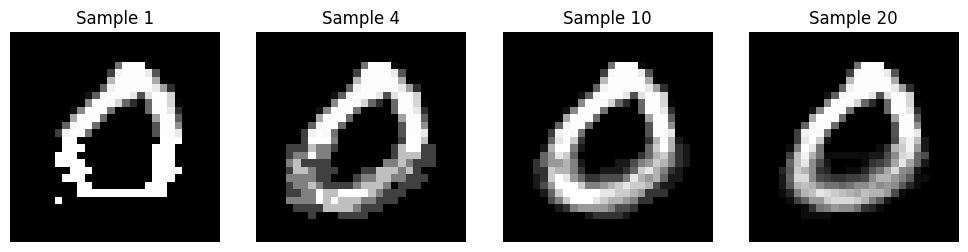

In [14]:
generate_and_plot(
    mps=mps_4_5, sample=img_0_flatten, gen_indices=gen_indices, sample_nums=[1, 4, 10, 20]
)

##### From Weights (Experimental) from 4-5.ipynb

In [15]:
def generate_and_plot_exp(
    *, mps: MPS, sample: torch.Tensor | None, gen_indices: List[int] | None, sample_nums: List[int]
):
    images = []

    for sample_num in sample_nums:
        img = generate_sample_with_gmps(
            mps,
            sample=sample,
            sample_num=sample_num,
            gen_indices=gen_indices,
            feature_mapping=FEATURE_MAPPING,
            feature_mapping_kwargs=FEATURE_MAPPING_KWARGS,
        )
        img = img[4:]  # remove the first 4 bits
        img = img.reshape(28, 28)
        images.append(img)

    plt.figure(figsize=(10, 2.5))
    for i, img in enumerate(images):
        plt.subplot(1, len(sample_nums), i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Sample {sample_nums[i]}")
    plt.tight_layout()
    plt.show()

In [16]:
mps_exp = MPS.load_from_safetensors(
    "datasets/mps/mnist_experimental_mps.safetensors", requires_grad=False
)

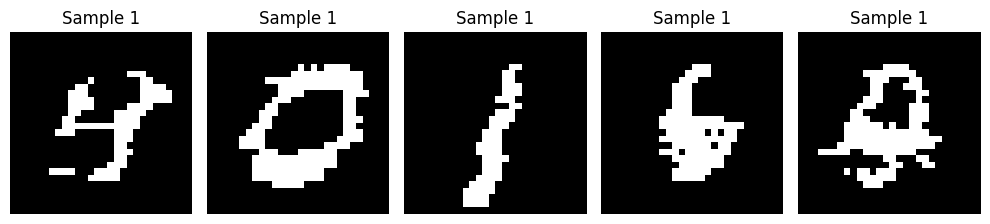

In [20]:
generate_and_plot_exp(mps=mps_exp, sample=None, gen_indices=None, sample_nums=[1] * 5)

In [21]:
from tensor_network.algorithms.gmps import labels_to_binary

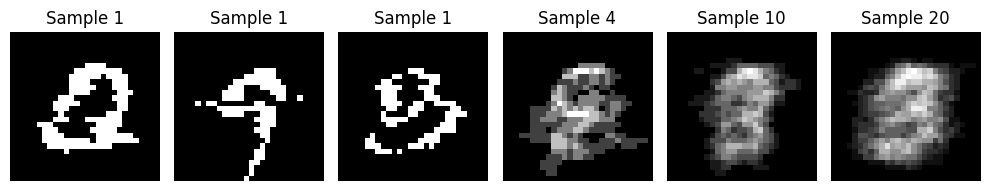

In [32]:
label = 9

label = labels_to_binary(torch.tensor([label]), num_bits=4)
sample = torch.cat([label, torch.zeros(1, 28 * 28)], dim=1)
gen_indices = list(range(4, 4 + 28 * 28))

generate_and_plot_exp(
    mps=mps_exp, sample=sample, gen_indices=gen_indices, sample_nums=[1, 1, 1, 4, 10, 20]
)

## 一些讨论

* 可考虑**多点采样进行生成**。上述例子为逐点地对图像实现生成，每次生成相当于选择$A$为已知与已生成的所有像素位置，$B$为当前需生成的像素位置，$C$为其余像素的位置。显然，我们可以修改程序，实现多个像素的同时生成，即将$B$选择为多个未知像素的位置，计算相应的约化密度矩阵及条件概率。

* **灰度像素的生成**。目前的投影测量是在$\{|0\rangle,|1\rangle\}$基底下进行的，因此单次生成的方式仅能给出黑 (0) 或白 (1) 色像素（基底的选择需与特征映射匹配）。灰度像素可通过多次生成的（经典）期望给出，但这显然不是生成灰度图的唯一方式。例如，我们可以考虑利用量子期望来生成灰度像素，由于$\{|0\rangle,|1\rangle\}$基底对应于$\hat{\sigma}^{(z)}$的本征态，可利用$x_m = \langle\hat{\sigma}^{(z)}\rangle = \text{Tr}(\hat{\rho}^{(m)}\hat{\sigma}^{(z)})$实现生成。又如，我们可考虑直接寻找概率最大的值来给出生成的结果，即生成的像素满足$x_m \rightarrow |\phi_m\rangle = \text{argmax}_{\langle\phi_m|\hat{\rho}^{(m)}|\phi_m\rangle}$（参考公式(4-54)）。